# Bistable toggle switch

The simplest GRN exhibiting bistability can be modeled through two variables $x_1$ and $x_2$ that mutually repress each othe. We suppose that the system can be externally controlled by a chemical inducer that targets the synthesis rates of both genes. The model is defined as
$$
\left\{ \begin{array}{l}
\dot{x}_1 = -\gamma_1 x_1 + u(t) k_1 s^{-}(x_2,\theta_2) , \\
\dot{x}_2 = -\gamma_2 x_2 + u(t) k_2  s^{-}(x_1,\theta_1),
\end{array}\right.
$$
where a detail of each term can be found in [Introduction](index.md#context). The domain $K=[0,k_1 / \gamma_1]\times [0,k_2 / \gamma_2]$ is forward invariant by the dynamics, which divides the state space into four regions:
$$
\begin{array}{l}
B_{00}=\left\{(x_1,x_2)\in \mathbb{R}^2 \mid 0<x_1<\theta_1, \ 0<x_2<\theta_2\right\},\\
B_{01}=\left\{(x_1,x_2)\in \mathbb{R}^2 \mid 0<x_1<\theta_1, \ \theta_2<x_2<\frac{k_2}{\gamma_2}\right\},\\
B_{10}=\left\{(x_1,x_2)\in \mathbb{R}^2 \mid \theta_1<x_1<\frac{k_1}{\gamma_1}, \ 0<x_2<\theta_2\right\},\\
B_{11}=\left\{(x_1,x_2)\in \mathbb{R}^2 \mid \theta_1<x_1<\frac{k_1}{\gamma_1}, \ \theta_2<x_2<\frac{k_2}{\gamma_2}\right\},
\end{array}
$$
and two locally asymptotically stable steady states
$$
\begin{align}
    \nonumber \phi_{10} &= \left(\frac{k_1}{\gamma_1},0\right)\in \bar{B}_{10}, \\
    \nonumber \phi_{01} &= \left(0,\frac{k_2}{\gamma_2}\right)\in \bar{B}_{01},
\end{align}
$$
as shown in the following figure:

![Alt Text](bistable.png)

The control objective is to induce a transition between an initial point in $B_{10}$ and a final value of $x_2$ in $B_{01}$, which can be written through the initial and terminal constraints:
$$
    x(0) = x_0 \in B_{10}, \qquad x_1(t_f) < \theta_1, \qquad x_2(t_f) = x_2^f
$$
for free final time $t_f > 0$ and for $x_2^f > \theta_2$.

## Problem definition

In [1]:
using Plots
using Plots.PlotMeasures
using OptimalControl
using NLPModelsIpopt
nothing # hide

┌ Warning: MKL is not available/installed.
└ @ MKL ~/.julia/packages/MKL/Ne2Fu/src/MKL.jl:39


We define the regularization functions, where the method is decided through the argument `regMethod`.

In [2]:
# Regularization of the PWL dynamics
function s⁺(x, θ, regMethod)
    if regMethod == 1 # Hill
        out = x^k/(x^k + θ^k)
    elseif regMethod == 2 # Exponential
        out = 1 - 1/(1 + exp(k*(x-θ)))
    end
    return out
end

# Regularization of |u(t) - 1|
function abs_m1(u, regMethod)
    if regMethod == 1 # Hill
        out = (u^k - 1)/(u^k + 1)
    elseif regMethod == 2 # Exponential
        out = 1 - 2/(1 + exp(k*(u-1)))
    end
    return out*(u - 1)
end
nothing # hide

Definition of the OCP:

In [3]:
# Constant definition
k₁ = 1;
k₂ = 1     # Production rates
γ₁ = 1.4;
γ₂ = 1.6   # Degradation rates
θ₁ = 0.6;
θ₂ = 0.4   # Transcriptional thresholds
uₘᵢₙ = 0.6;
uₘₐₓ = 1.4   # Control bounds
x₀ = [0.65, 0.2]         # Initial point
x₂ᶠ = 0.55                # Final point
λ = 0.25                # Trade-off fuel/time

# Initial guest for the NLP
tf = 1.5
u(t) = 0
sol = (control=u, variable=tf)

# Optimal control problem definition
ocp = @def begin
    tf ∈ R, variable
    t ∈ [0, tf], time
    x = (x₁, x₂) ∈ R², state
    u ∈ R, control

    x(0) == x₀
    x₁(tf) ≤ θ₁
    x₂(tf) == x₂ᶠ

    uₘᵢₙ ≤ u(t) ≤ uₘₐₓ
    tf ≥ 0

    ẋ(t) == [
        - γ₁*x₁(t) + k₁*u(t)*(1 - s⁺(x₂(t), θ₂, regMethod)),
        - γ₂*x₂(t) + k₂*u(t)*(1 - s⁺(x₁(t), θ₁, regMethod)),
    ]

    ∫(λ*abs_m1(u(t), regMethod) + 1-λ) → min
end
nothing # hide

## Resolution through Hill regularization

In order to ensure convergence of the solver, we solve the OCP by iteratively increasing the parameter $k$ while using the $i-1$-th solution as the initialization of the $i$-th iteration.

In [4]:
regMethod = 1       # Hill regularization
ki = 50             # Value of k for the first iteration
N = 400
maxki = 200          # Value of k for the last iteration
while ki < maxki
    global ki += 50  # Iteration step
    local print_level = (ki == maxki) # Only print the output on the last iteration
    global k = ki
    global sol = solve(ocp; grid_size=N, init=sol, print_level=4*print_level)
end
nothing # hide

▫ This is OptimalControl version v1.1.1 running with: direct, adnlp, ipopt.

▫ The optimal control problem is solved with CTDirect version v0.16.2.

   ┌─ The NLP is modelled with ADNLPModels and solved with NLPModelsIpopt.
   │
   ├─ Number of time steps⋅: 400
   └─ Discretisation scheme: trapeze

▫ This is OptimalControl version v1.1.1 running with: direct, adnlp, ipopt.

▫ The optimal control problem is solved with CTDirect version v0.16.2.

   ┌─ The NLP is modelled with ADNLPModels and solved with NLPModelsIpopt.
   │
   ├─ Number of time steps⋅: 400
   └─ Discretisation scheme: trapeze

▫ This is OptimalControl version v1.1.1 running with: direct, adnlp, ipopt.

▫ The optimal control problem is solved with CTDirect version v0.16.2.

   ┌─ The NLP is modelled with ADNLPModels and solved with NLPModelsIpopt.
   │
   ├─ Number of time steps⋅: 400
   └─ Discretisation scheme: trapeze

Total number of variables............................:     1605
                     variables with 

Plotting of the results:

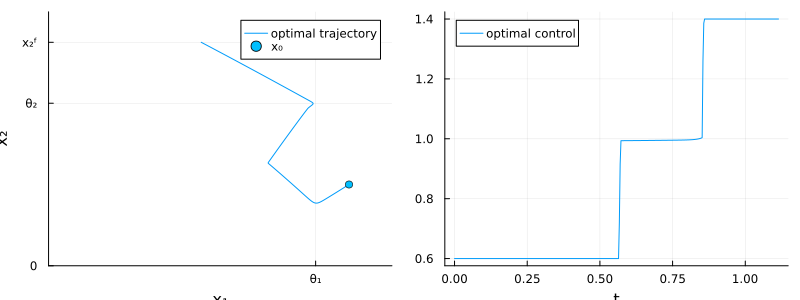

In [5]:
plt1 = plot()
plt2 = plot()

tf = variable(sol)
tspan = range(0, tf, N)   # time interval
x₁(t) = state(sol)(t)[1]
x₂(t) = state(sol)(t)[2]
u(t) = control(sol)(t)

xticks = ([0, θ₁], ["0", "θ₁"])
yticks = ([0, θ₂, x₂ᶠ], ["0", "θ₂", "x₂ᶠ"])

plot!(
    plt1,
    x₁.(tspan),
    x₂.(tspan);
    label="optimal trajectory",
    xlabel="x₁",
    ylabel="x₂",
    xlimits=(θ₁/3, k₁/γ₁),
    ylimits=(0, k₂/γ₂),
)
scatter!(plt1, [x₀[1]], [x₀[2]]; label="x₀", color=:deepskyblue)
xticks!(xticks)
yticks!(yticks)
plot!(plt2, tspan, u; label="optimal control", xlabel="t")
plot(plt1, plt2; layout=(1, 2), size=(800, 300))

## Resolution through exponential regularization

The same procedure for iteratively increasing $k$ is used.

In [6]:
regMethod = 2       # Exponential regularization
ki = 50             # Value of k for the first iteration
N = 400
maxki = 300          # Value of k for the last iteration
while ki < maxki
    global ki += 50  # Iteration step
    local print_level = (ki == maxki) # Only print the output on the last iteration
    global k = ki
    global sol = solve(ocp; grid_size=N, init=sol, print_level=4*print_level)
end
nothing # hide

▫ This is OptimalControl version v1.1.1 running with: direct, adnlp, ipopt.

▫ The optimal control problem is solved with CTDirect version v0.16.2.

   ┌─ The NLP is modelled with ADNLPModels and solved with NLPModelsIpopt.
   │
   ├─ Number of time steps⋅: 400
   └─ Discretisation scheme: trapeze

▫ This is OptimalControl version v1.1.1 running with: direct, adnlp, ipopt.

▫ The optimal control problem is solved with CTDirect version v0.16.2.

   ┌─ The NLP is modelled with ADNLPModels and solved with NLPModelsIpopt.
   │
   ├─ Number of time steps⋅: 400
   └─ Discretisation scheme: trapeze

▫ This is OptimalControl version v1.1.1 running with: direct, adnlp, ipopt.

▫ The optimal control problem is solved with CTDirect version v0.16.2.

   ┌─ The NLP is modelled with ADNLPModels and solved with NLPModelsIpopt.
   │
   ├─ Number of time steps⋅: 400
   └─ Discretisation scheme: trapeze

▫ This is OptimalControl version v1.1.1 running with: direct, adnlp, ipopt.

▫ The optimal control p

Plotting of the results:

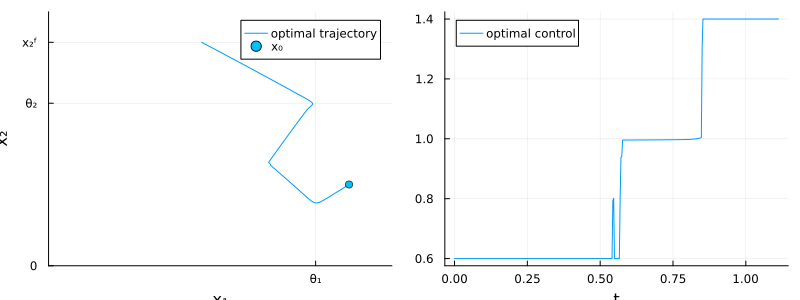

In [7]:
plt1 = plot()
plt2 = plot()

tf = variable(sol)
tspan = range(0, tf, N)   # time interval
x₁(t) = state(sol)(t)[1]
x₂(t) = state(sol)(t)[2]
u(t) = control(sol)(t)

xticks = ([0, θ₁], ["0", "θ₁"])
yticks = ([0, θ₂, x₂ᶠ], ["0", "θ₂", "x₂ᶠ"])

plot!(
    plt1,
    x₁.(tspan),
    x₂.(tspan);
    label="optimal trajectory",
    xlabel="x₁",
    ylabel="x₂",
    xlimits=(θ₁/3, k₁/γ₁),
    ylimits=(0, k₂/γ₂),
)
scatter!(plt1, [x₀[1]], [x₀[2]]; label="x₀", color=:deepskyblue)
xticks!(xticks)
yticks!(yticks)
plot!(plt2, tspan, u; label="optimal control", xlabel="t")
plot(plt1, plt2; layout=(1, 2), size=(800, 300))

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*